<img align="center" style='max-width: 1000px' src="images/banner.png">

<img align="left" style='max-width: 150px; height: auto' src="images/hsg_logo.png">

# Lab 02 - "Continual Learning"


## Outline

### 1. Why Continual Learning?
- What is continual learning about in practice?
- How does forgetting happen in neural networks?

### 2. Avalanche
- Main Avalanche components
- Implementing continual learning strategies in Avalanche

## Objective

After learning the concepts in this lab, you should be able to:

- Identify and formulate a continual learning problem
- Create a continual stream of data from a static dataset
- Implement new algorithms for continual learning using Avalanche



## Packages

In [1]:
# !pip install avalanche-lib

In [3]:
import torch
import torch.nn as nn

import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# <font color='red'>1. Continual Learning</font>


What do we exactly want to do in practice? let's start with a demo:


https://www.youtube.com/watch?v=Bs3tSjwbHa4

Continual learning is useful for the cases where we have consistent shift in the data.

#### Distribution Changes
Data distributions can change over time -> predictions can become less accurate
<img align="center" width="700" src="images/segmentation.png">

Source: https://arxiv.org/abs/2011.11390


#### Training Costs and Sustainability

- Training from scratch for every new batch of data is not sustainable for large models and it can be very expensive.
- Training a single GPT-3 model is ~4.6 Million dolalrs!
- Maintanance costs can be very expensive

#### Theoretical and Biological Reasons
- Theoretical reasons: can continual learning lead to better solutions?
<img align="center" width="700" src="images/biological_mechanisms.png">

Source: https://www.socsci.uci.edu/~jkrichma/Kudithipudi-BiologicalUnderpinnings-NatMachIntel-2022.pdf

- Can we achieve a better solution via continual learning?
- Recent works have shown that JointTraining is a "soft" upper-bound for continual learning!

#### One Big Challenge
Catastrophic forgetting.
There is no guarantee that the model trained on the new data would not lose its performance on previous data.



### 1.2 Catastrophic Forgetting

Toy example: we want to classify data samples from a 2D blobs dataset.

In [4]:
import sklearn.datasets

In [5]:
def get_blobs_dataset(classes):
    """ Creates and returns blobs datataset for a given list of classes."""
    
    # Generate Blobs
    X, Y = sklearn.datasets.make_blobs(n_samples=500, centers=6, n_features=2,
                                       random_state=7, cluster_std=1.8)
    
    # Convert numpy arrays to PyTorch tensors.
    X = torch.FloatTensor(X)
    Y = torch.LongTensor(Y)
    
    # Placeholder for list of tensors from the given list of classes
    X_ = []
    Y_ = []
    
    # Only add the tensors in the class list
    for c in classes:
        X_.append(X[torch.where(Y==c)])
        Y_.append(Y[torch.where(Y==c)])
    
    # Concat the class tensor lists and return them
    X = torch.cat(X_, dim=0)
    Y = torch.cat(Y_, dim=0)
    
    return X, Y

We create a dataset of blobs, and split it into two separate tasks:

Text(0.5, 1.0, 'Task 2')

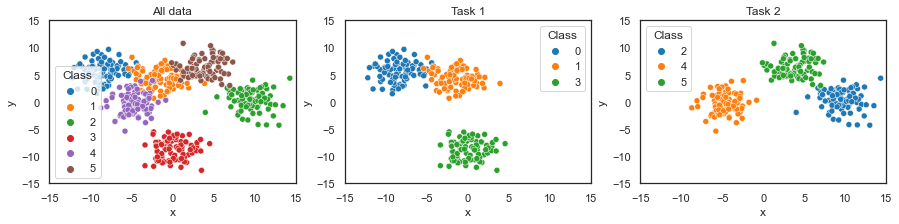

In [9]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3)

# Plot data from all classes
X, Y = get_blobs_dataset(classes=[0, 1, 2, 3, 4, 5])
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[0], palette="tab10")
ax[0].set_xlim([-15, 15])
ax[0].set_ylim([-15, 15])
ax[0].set_title("All data")

# Plot Task 1 data
X, Y = get_blobs_dataset(classes=[0, 1, 3])
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[1], palette="tab10")
ax[1].set_xlim([-15, 15])
ax[1].set_ylim([-15, 15])
ax[1].set_title("Task 1")

# Plot Task 2 data
X, Y = get_blobs_dataset(classes=[2, 4, 5])
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[2], palette="tab10")
ax[2].set_xlim([-15, 15])
ax[2].set_ylim([-15, 15])
ax[2].set_title("Task 2")


We want to train a model in two different ways:

- Using all data together
- First train on task 1 data and then train on task 2 data

In [10]:
class MLP(nn.Module):
    """ Implementation of a simple MLP with two hidden layers. """
    def __init__(self, n_classes=2):
        super().__init__()
        self.linear1 = nn.Linear(2, 10)
        self.linear2 = nn.Linear(10, n_classes)
        self.nonlin = nn.Tanh()

    def forward(self, x):
        x = self.nonlin(self.linear1(x))
        x = self.linear2(x)
        return x


We train the model with the standard steps using SGD optimizer and cross entropy criterion.

In [11]:
def train_model(classes=[0, 1, 2], n_epochs=100, model=None):
    """ Trains a model for a given set of classes.
    
        classes: list of classes to use for training.
        n_epochs: number of training epochs
        model: the model to use for training.
    """
    # If no model is given, define a model with random intialization
    if model == None:
        model = MLP(n_classes=6)
    
    # Initialize criterion, optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    
    # Initialize datasets with the given set of classes
    X, Y = get_blobs_dataset(classes)

    # Progress bar
    progress = tqdm.tqdm(list(range(n_epochs)))
    
    # Training epochs
    for epoch in progress:
        model.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()
        
        progress.update()
    
    return model

And finally, after training the model, we plot the decision boundary of the model.

In [20]:
def plot_decision_boundary(model, classes, title=""):
    """ Plot model decision bounday."""
    
    # Creat meshgrid for a box range of [-15, 15] for x and y
    x_ = torch.linspace(-15, 15, 2000)
    y_ = torch.linspace(-15, 15, 2000)
    xx, yy = torch.meshgrid(x_, y_)
    
    # Compute model predicition for the meshgrid
    xx_model = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)
    
    # Compute contour depth
    zz = torch.argmax(model(xx_model), dim=1).reshape(2000, 2000)
    
    # Plot decision boundary
    fig, ax = plt.subplots(figsize=(5, 5))
    X, Y = get_blobs_dataset(classes=classes)
    data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
    ax.contourf(xx, yy, zz, cmap=plt.cm.RdYlBu, alpha=0.5)
    ax.set_title(title)
    
    # Plot samples from the given list of classes
    sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax, palette="tab10")
    

#### Joint Training

In the first scenario, we use the whole dataset to train a model.

100%|██████████| 200/200 [00:00<00:00, 2048.30it/s]


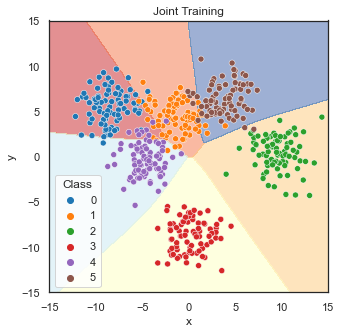

In [21]:
model = train_model(classes=[0, 1, 2, 3, 4, 5], n_epochs=200)
plot_decision_boundary(model, classes=[0, 1, 2, 3, 4, 5], title="Joint Training")

#### Class-Incremental Learning

In the second scenario, we split the classes as below to train the model in two episodes:

In [16]:
task1 = [0, 4, 5]
task2 = [1, 2, 3]

Train the model on task 1:

100%|██████████| 300/300 [00:00<00:00, 2207.94it/s]


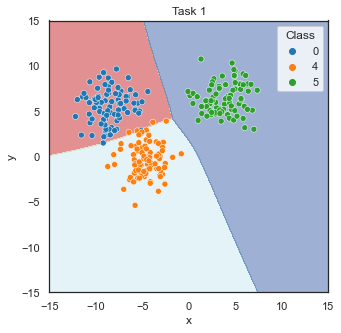

In [23]:
# Train model from a random initilization
model_task1 = train_model(classes=task1, n_epochs=300)

# Plot decision boundary for task 1
plot_decision_boundary(model_task1, classes=task1, title="Task 1")

Train the model on task 2:

100%|██████████| 300/300 [00:00<00:00, 1455.83it/s]


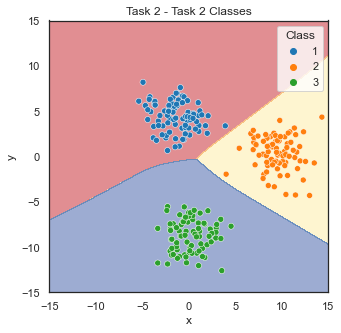

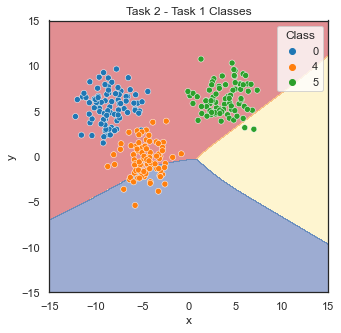

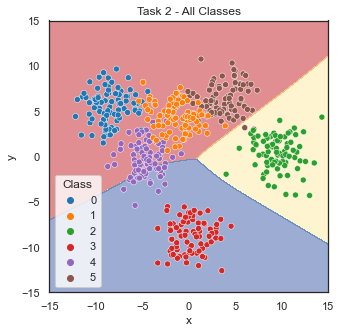

In [25]:
# Train model using previoudly train model on task 1
model_task2 = train_model(classes=task2, model=model_task1, n_epochs=300)

# Plot decision boundary for task 2
plot_decision_boundary(model_task2, classes=task2, title="Task 2 - Task 2 Classes")

# Plot decision boundary for task 2
plot_decision_boundary(model_task2, classes=task1, title="Task 2 - Task 1 Classes")

# Plot decision boundary for task 2
plot_decision_boundary(model_task2, classes=task1+task2, title="Task 2 - All Classes")

#### Further Notes
Continual learning is not just about catastrophic forgetting!

- Knoweldge transfer
- Forward Transfer (Zero-Shot Learning)
- Backward Transfer


<img align="center" width="500" src="images/amazon_cl.png">

Source: https://arxiv.org/abs/1903.05202

# <font color='red'>2. Avalanche</font>


Avalanche is an end-to-end library for continual learning.

Avalanche is one of the open source products of Continual AI: 

https://www.continualai.org/


<img align="center" width="400" src="images/avalanche.png">

Link: https://avalanche.continualai.org/







Data streams consist of sequence of experiences where each experience contains one dataset:

<img align="center" width="500" src="images/avalanche_stream.png">


### 2.1 Benchmark

Link: https://avalanche-api.continualai.org/en/v0.2.1/benchmarks.html



#### Domain-Incremental:

Example: Rotated MNIST

<img align="center" width="600" src="images/benchmark_rotmnist.png">


In [27]:
from avalanche.benchmarks import RotatedMNIST

benchmark = RotatedMNIST(n_experiences=5, return_task_id=False, dataset_root="./data")

In [31]:
for experience in benchmark.train_stream:
    print(f"Experience {experience.current_experience}")
    print(experience.classes_in_this_experience)
    print()

Experience 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 4
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



#### Class-Incremental:

Example: Split-MNIST

<img align="center" width="600" src="images/benchmark_splitmnist.png">


In [33]:
from avalanche.benchmarks import SplitMNIST

benchmark = SplitMNIST(n_experiences=5, return_task_id=False, dataset_root="./data")

In [34]:
for experience in benchmark.train_stream:
    print(f"Experience {experience.current_experience}")
    print(experience.classes_in_this_experience)
    print()

Experience 0
[0, 4]

Experience 1
[2, 7]

Experience 2
[3, 5]

Experience 3
[1, 9]

Experience 4
[8, 6]



### 2.2 Head Type

#### Class-Incremental:

- Single-head model
- Task ID is used for training or inference

<img align="center" width="300" src="images/single-head.png">


#### Task-Incremental:

- Multi-head model
- Task ID is used for training and inference

<img align="center" width="300" src="images/multi-head.png">


#### Domain-Incremental:

- Single-head model
- No Task ID needed

### 2.3 Training and Strategies

#### Templates:

- Avalanche provides pre-defined templates for common training settings.
- For example: for supervised continual learning, it provides a base trainer called Naive strategy.
- The training steps are defined within the templates.

```
train
    before_training

    before_train_dataset_adaptation
    -> train_dataset_adaptation
    after_train_dataset_adaptation
    -> make_train_dataloader
    -> model_adaptation
    -> make_optimizer
    before_training_exp  
        before_training_epoch  
            before_training_iteration
                before_forward
                after_forward
                before_backward
                after_backward
            after_training_iteration
            before_update
            after_update
        after_training_epoch
    after_training_exp
    
    after_training
    
```

In [41]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Avalanche imports
from avalanche.models import SimpleMLP
from avalanche.training.supervised import Naive

Initialize model, optimizer and criterion as always:

In [42]:
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

Initialize benchmark:

In [56]:
# Benchmark
benchmark = SplitMNIST(n_experiences=5, seed=1)


Define strategy: a strategy is an algorithm that is provided with:
- Model
- Optimizer
- Criterion
- Sequence of Experiences (correspondigly Datasets)

and updates the model in each episode of learning.

For example the following strategy called Naive is also referred to as sequential fine-tuning:

In [59]:
strategy = Naive(
    model, 
    optimizer, 
    criterion,
    train_mb_size=100, 
    train_epochs=4, 
    eval_mb_size=100
)

#### Main training loop

Since the strategy takes care of all training steps, the main training loop in avalanche is over the stream of experiences:

In [55]:

# Iterate over stream experiences and call strategy.train() for every experience

results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream)
    results.append(res)

200it [00:25, 47.59it/s]

In [51]:
# print(results[0])

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2.4 Plugins

- A simple way to implement an strategy is to extend the Naive (or an existing) strategy through plugins.

- Plugins consist of functions that are triggered after particular steps of the training loop

### 2.5 Popular Continual Learning Strategies 


#### Replay 

Replay extends the Naive strategy by using an external buffer to store a subset of samples from previous experiences.

The samples are either randomly added to the dataloader or are chosen based on a particular storage/selection policy in each batch.

We can implement replay as a plugin:

- After training on each experience, add random samples from the current experience to the buffer.
- Before starting to train on the next experience, add buffer samples to the dataloader.

In [60]:
from avalanche.training.plugins import ReplayPlugin

replay_plugin = ReplayPlugin(mem_size=100)

Now, we can extend Naive strategy with the replay plugin:

In [72]:
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

strategy = Naive(
    model, optimizer, criterion,
    plugins=[replay_plugin],
    device=device
)

And the same training loop as before:

In [74]:
# scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream)
    results.append(res)

#### Gradient Episodic Memory (GEM) 



<img align="center" width="300" src="images/gem.png">

Source: https://zhangruochi.com/Lifelong-Learning/2020/03/14/

In [76]:
from avalanche.training.plugins import GEMPlugin

gem_plugin = GEMPlugin(patterns_per_experience=100, memory_strength=0.5)

In [77]:
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

strategy = Naive(
    model, optimizer, criterion,
    plugins=[gem_plugin],
    device=device
)

In [79]:
# scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream)
    results.append(res)

### 2.6 Hybrid Strategies


Example: Combining EWC with Replay

$L = L_{CE} + \alpha * L_{EWC} + \beta L_{Replay}$

Description: TBA

In [86]:
from avalanche.training.supervised import Naive
from avalanche.training.plugins import EWCPlugin, GEMPlugin

model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


Define multiple plugins and add them to the strategy

In [84]:
gem_plugin = GEMPlugin(patterns_per_experience=100, memory_strength=0.5)
ewc_plugin = EWCPlugin(ewc_lambda=0.1)

strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=64, train_epochs=3, eval_mb_size=64,
    plugins=[gem_plugin],
    device=device
)


Device:  cpu


### 2.7 Implementing Your Own Strategy as a Plugin

Description: TBA

In [87]:
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin


class MyRegularizer(SupervisedPlugin):
    """ Implementation of MyReularizer plugin."""
    def __init__(self, alpha=1.0):
        super().__init__()
        
        # Regularizer weight
        self.alpha = alpha

    def after_backward(self, strategy, **kwargs):
        # Compute L1 regularization loss
        l1_parameters = []
        for parameter in mlp.parameters():
            l1_parameters.append(parameter.view(-1))
        l1_reg_loss = mlp.compute_l1_loss(torch.cat(l1_parameters))
        
        # Add loss to the strategy's loss
        strategy.loss += self.alpha * l1_reg_loss
        

In [88]:
my_regularizer = MyRegularizer(alpha=0.5)

strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=64, train_epochs=3, eval_mb_size=64,
    device=device,
    plugins=[my_regularizer]
)
